In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.optimize import minimize

from scipy.stats import norm

from astropy.io import fits

from coprofile import COGenerator

from likelihood import ModelLikelihood, FunctionModelLikelihood, SampleInverter

import pyunfold as pu

In [59]:
def log_gauss(x, cov):
    log_det = np.log(np.linalg.det(2*np.pi*cov))
    cov_inv = np.linalg.inv(cov)
    return -(np.matmul(x, np.matmul(cov_inv, x)) + log_det)/2

In [30]:
def unif_dist(low, high):
    return (low + high)/2, (high-low)**2/12

In [3]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [4]:
fmu_neg, fmu_fast = 0.066, 0.072
f_ratio = fmu_fast/fmu_neg

In [5]:
mu_neg_file, mu_fast_file = 'models/balco_14co_delta_neg_models.fits', 'models/balco_14co_delta_fast_models.fits'

In [6]:
hdus_neg = fits.open(mu_neg_file)

# Set up mu_neg 14CO profiles.
z_neg = hdus_neg['DEPTH'].data
co14_neg = hdus_neg['CO14'].data
t_spike_neg = hdus_neg['T_SPIKE'].data['T_SPIKE']

order = np.argsort(-t_spike_neg)

z = z_neg
t = np.array(t_spike_neg[order])
CO_neg = np.array(co14_neg[order])#[:,1:]


hdus_fast = fits.open(mu_fast_file)

# Set up mu_fast 14CO profiles.
z_fast = hdus_fast['DEPTH'].data
co14_fast = hdus_fast['CO14'].data
t_spike_fast = hdus_fast['T_SPIKE'].data['T_SPIKE']

order = np.argsort(-t_spike_fast)

# axis0 = time, axis1 = depth
CO_fast = np.array(co14_fast[order])#[:,1:]
        
# axis0: depth, axis1: time
G = np.append(CO_neg, CO_fast, axis=0).T
        
step = int(20 / np.diff(z)[0])
i = np.arange(0, len(G), step)
i = np.append(i,len(G))

comp = np.zeros((len(i)-1, len(G)))
for x in range(len(i)-1):
    comp[x, i[x]:i[x+1]] = 1/(i[x+1]-i[x])
            
z_samp = np.matmul(comp, z)
t_samp = np.matmul(comp, np.append(t,[0]))
        
G_comp = np.matmul(comp, G)

In [7]:
# Let's setup a prior on f

# The prior goes as 1/f
# each f value over time is independent of the others
# lower bound: 0.0001
# upper bound: 1.
# p(f) = prod 1/(4log(10) f)

# from this prior, we can calculate the prior on our model and the prior on our data

f_low = 0.
f_high = 1.
#norm = np.log(f_high)-np.log(f_low)
norm = f_high - f_low

# building prior on CO' from prior on f
# average f = (upper bound - lower bound) / (log upper bound - log lower bound) = 0.9999 / 4log(10)
# var f = (upper bound^2 - lower bound^2) / 2(log upper bound - log lower bound) - (average f)^2

#f_avg = (f_high - f_low) / norm
#f_var = (f_high**2 - f_low**2) / (2*norm) - f_avg**2

f_avg = (f_high + f_low)/2
f_var = (f_high - f_low)**2/12

In [8]:
# Model definition

f_0 = np.append(0*t + fmu_neg, 0*t + fmu_fast)
f_bound = 0.015

#f_cov = np.diag((f_0*f_bound)**2/3)

f_cov = np.zeros((len(f_0),len(f_0)))
f_cov[:len(f_0),:len(f_0)] = (fmu_neg*f_bound)**2/3
f_cov[len(f_0):,len(f_0):] = (fmu_fast*f_bound)**2/3

In [9]:
CO_0 = np.matmul(G_comp, f_0)

M_cov = np.matmul(G_comp, np.matmul(f_cov, G_comp.T)) # model covariance matrix

In [10]:
pCO = np.matmul(G_comp, np.full(len(f_0), f_avg))

pf_cov = np.diag(np.full(len(f_0), f_var))
pCO_cov = np.matmul(G_comp, np.matmul(pf_cov, G_comp.T))

In [11]:
#logpM = log_gauss(CO_0 - pCO, M_cov + pCO_cov)

#logpM = np.sum(np.log((np.log(np.ones(len(f_0))+f_bound) - np.log(np.ones(len(f_0))-f_bound)) / norm)) # probability of Model given prior
logpM = np.sum(np.log(2*f_0*f_bound)-np.log(norm))

In [12]:
logpM

-90034.67089504427

In [13]:
generator = COGenerator(mu_neg_file, mu_fast_file)

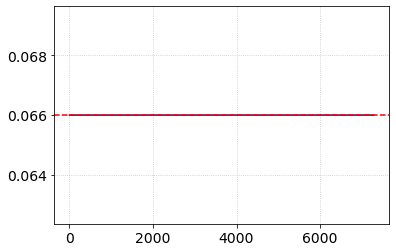

In [14]:
t_scale = (t-t[0])/(t[0]-t[-1])

#amp = 1-0.5*t_scale
#amp = 1-0.1*np.sin(np.pi*t_scale)
amp = np.ones(len(t))

f_neg = fmu_neg*amp
f_fast = fmu_fast*amp

plt.plot(t,f_neg)
plt.axhline(fmu_neg, ls='--', c='red')

In [15]:
# we need to flip f_neg and f_fast because the profile generator doesn't expect time to be in reverse order.
const_profile = generator.generate(f_neg = np.flip(f_neg), f_fast = np.flip(f_fast), rel_uncertainty=0.02)

In [16]:
z_samp2, CO_samp, dCO_samp = const_profile.sample_z()

S_cov = np.diag(dCO_samp**2) # sample covariance matrix

In [17]:
logL = log_gauss(CO_samp - CO_0, S_cov + M_cov)

In [18]:
logL

-7.072992969511304

In [19]:
logpS = log_gauss(CO_samp - pCO, S_cov + pCO_cov)

In [20]:
logpS

-13922.747812549615

In [21]:
prob = np.exp(logL + logpM - logpS)

In [22]:
prob

0.0

Text(0.5, 1.0, 'Constant CO Profile Sample')

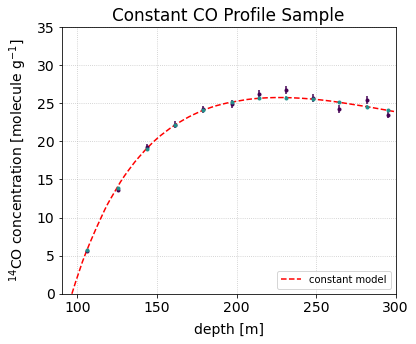

In [23]:
z_samp2, CO_samp, dCO_samp = const_profile.sample_z()

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.errorbar(z_samp, pCO, yerr=np.sqrt(np.diag(pCO_cov)), fmt='.')
ax.errorbar(z_samp, CO_0, yerr=np.sqrt(np.diag(M_cov)), fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample')

In [65]:
# constant model

# function paramters:
# 0 : height in f_neg
# 1 : height in f_fast

h_neg = np.append(np.ones(len(t)), np.zeros(len(t)))
h_fast = np.append(np.zeros(len(t)), np.ones(len(t)))

const_func = np.matmul(G_comp, np.array([h_neg, h_fast]).T)

h_neg_min, h_neg_max = 0.06, 0.08
h_fast_min, h_fast_max = 0.06, 0.08

h_neg_avg, h_neg_var = unif_dist(h_neg_min, h_neg_max)
h_fast_avg, h_fast_var = unif_dist(h_fast_min, h_fast_max)

const_cov_param = np.diag([h_neg_var, h_fast_var])
const_avg_param = np.array([h_neg_avg, h_fast_avg])

const_cov = np.matmul(const_func, np.matmul(const_cov_param, const_func.T))
const_avg = np.matmul(const_func, const_avg_param)

In [53]:
# linear model

# function parameters:
# 0 : height in f_neg
# 1 : height in f_fast
# 2 : slope in f_neg
# 3 : slope in f_fast

t_scale = (t-t[0])/(t[0]-t[-1])

h_neg = np.append(np.ones(len(t)), np.zeros(len(t)))
h_fast = np.append(np.zeros(len(t)), np.ones(len(t)))
s_neg = np.append(t_scale, np.zeros(len(t)))
s_fast = np.append(np.zeros(len(t)), t_scale)

lin_func = np.matmul(G_comp, np.array([h_neg, h_fast, s_neg, s_fast]).T)

# s_neg = h_neg * amp
# s_fast = h_fast * amp
# h_neg, h_fast, and amp are all independent (assume)

h_neg_min, h_neg_max = 0.06, 0.08
h_fast_min, h_fast_max = 0.06, 0.08
amp_min, amp_max = -0.5, 0.5

h_neg_avg, h_neg_var = unif_dist(h_neg_min, h_neg_max)
h_fast_avg, h_fast_var = unif_dist(h_fast_min, h_fast_max)
amp_avg, amp_var = unif_dist(amp_min, amp_max)

lin_cov_param = np.zeros((4, 4))

# var(s_neg) = <s_neg^2> - <s_neg>^2 = <h_neg^2> <amp^2> - <h_neg>^2 <amp>^2 = var(h_neg) var(amp) + var(h_neg) <amp>^2 + <h_neg>^2 var(amp)
# cov(s_neg, h_neg) = <s_neg h_neg> - <s_neg> <h_neg> = <h_neg^2 amp> - <h_neg amp> <h_neg> = (<h_neg^2> - <h_neg>^2) <amp>
# cov(s_fast, h_fast) = var(h_neg) <amp>
# cov(s_fast, s_neg) = var(amp) <h_fast> <h_neg>

lin_cov_param[0,0] = h_neg_var

lin_cov_param[1,1] = h_fast_var

lin_cov_param[2,2] = h_neg_var * amp_var + h_neg_var * amp_avg + h_neg_avg * amp_var
lin_cov_param[2,0] = h_neg_var * amp_avg
lin_cov_param[0,2] = lin_cov_param[2,0]

lin_cov_param[3,3] = h_fast_var * amp_var + h_fast_var * amp_avg + h_fast_avg * amp_var
lin_cov_param[3,1] = h_fast_var * amp_avg
lin_cov_param[1,3] = lin_cov_param[3,1]
lin_cov_param[3,2] = amp_var * h_fast_avg * h_neg_avg
lin_cov_param[2,3] = lin_cov_param[3,2]

lin_avg_param = np.array([h_neg_avg, h_fast_avg, h_neg_avg * amp_avg, h_fast_avg * amp_avg])

lin_cov = np.matmul(lin_func, np.matmul(lin_cov_param, lin_func.T))
lin_avg = np.matmul(lin_func, lin_avg_param)

In [54]:
np.sqrt(np.diag(lin_cov))

array([ 0.36463394,  1.16136403,  2.19809933,  3.41648981,  4.71939185,
        6.03549853,  7.31639699,  8.53131006,  9.66079476, 10.69326746,
       11.62281476, 12.24993165])

In [55]:
lin_avg

array([ 5.79288142, 14.10905846, 19.19399097, 22.33133613, 24.22245778,
       25.28036426, 25.75258489, 25.82054664, 25.59621567, 25.16047627,
       24.57413767, 24.06318514])

Text(0.5, 1.0, 'Constant CO Profile Sample')

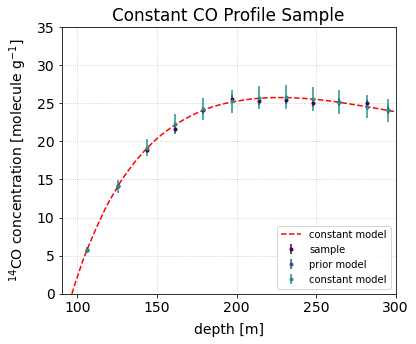

In [69]:
z_samp2, CO_samp, dCO_samp = const_profile.sample_z()

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.', label='sample')
ax.errorbar(z_samp, pCO, yerr=np.sqrt(np.diag(pCO_cov)), fmt='.', label='prior model')
ax.errorbar(z_samp, const_avg, yerr=np.sqrt(np.diag(const_cov)), fmt='.', label='constant model')
#ax.errorbar(z_samp, lin_avg, yerr=np.sqrt(np.diag(lin_cov)), fmt='.', label='linear model')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample')

In [70]:
np.exp(log_gauss(const_avg - CO_samp, const_cov + S_cov)-log_gauss(lin_avg - CO_samp, lin_cov + S_cov))

17.73570558131581

In [74]:
log_gauss(const_avg - lin_avg, const_cov + lin_cov)

122.23454479690776